In [ ]:
import scipy
import os
import numpy as np
import pandas as pd
from fooof.utils.io import load_fooofgroup as load_fooofgroup
from natsort import natsorted 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import pickle
import imageio.v2 as imageio  # For saving GIFs
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
import pickle
import seaborn as sns
from data_utils import reorganize_rois, reorder_hemispheres

In [2]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\ICA_pruned_reduced\\plot_indeces_organization", 'rb') as file:
    new_indices = pickle.load(file)

############################################################################################
def reorganize_roi_gradient(original_data, new_indices=new_indices):
  '''
  A function that reorder the atlas parcels for plot purposes

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    new_indices: a list.
      a list of the indeces in the new order
  Returns
  -------
    x: an array.
      the reordered data used for the cortical plot
  '''
  x = [original_data[i] for i in new_indices]
  return(np.array(x))
############################################################################################

############################################################################################
def reorder_hemispheres(original_data, first_left = True):
  '''
  A function that reorder the atlas parcels for plot purposes.

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    first_left: a boolean.
      True if we want all left hemispheres parcels before right hemisphere ones,
      False otherwise
  Returns
  -------
    ordered_data: a list.
      the reordered data used for the cortical plot. This will become the input for
      the reorganize_roi_gradient function
  '''
  left_h = []
  right_h = []
  for idx, val in enumerate(original_data):
    idx +=1
    if idx%2==0:
      right_h.append(val)
    else:
      left_h.append(val)
  if first_left:
    ordered_data = np.concatenate((left_h, right_h))
  else:
    ordered_data = np.concatenate((right_h, left_h))
  return ordered_data.tolist()

def mat_struct_to_dict(mat_obj):
    """ Recursively convert MATLAB structs to Python dictionaries """
    if isinstance(mat_obj, scipy.io.matlab.mio5_params.mat_struct):
        return {field: mat_struct_to_dict(getattr(mat_obj, field)) for field in mat_obj._fieldnames}
    elif isinstance(mat_obj, list):
        return [mat_struct_to_dict(item) for item in mat_obj]
    else:
        return mat_obj


def load_aperiodic_from_mat_files(parent_directory, aperiodic_component = 'exponent'):
    """
    Loads and extracts FOOOF aperiodic component data from all `.mat` files in the specified parent directory.
    This function iterates over all `.mat` files in the given directory, processes them by 
    and stores the results in a dictionary.

    Parameters:
    -----------
    parent_directory : str
        Path to the directory containing `.mat` files.
    aperiodic_component = str
        choose wich aperioding component to extract between 'exponent' and 'offset'

    Returns:
    --------
    data_dict : dict
        A dictionary where:
            - Keys are the subject names (extracted from file names, removing '_Sprint' if present).
            - Values are the extracted FOOOF exponent data from the `.mat` file.

    Notes:
    ------
    - Only files ending with `.mat` are considered.
    - The function assumes that the key in the loaded `.mat` structure matches the filename (without `.mat`).
    - Requires `scipy.io.loadmat` to load `.mat` files and `natsort.natsorted` for natural sorting.
    """
    # Initialize an empty dictionary to store results
    data_dict = {}

    # Iterate over each file in the parent directory, sorted naturally
    for file_name in natsorted(os.listdir(parent_directory)):  
        if file_name.endswith('.mat'):  # Consider only .mat files
            file_path = os.path.join(parent_directory, file_name)
            key_name = file_name.replace('.mat', '')
            dict_key = key_name.replace('_Sprint', '')

            print(f"Loading subject {dict_key} and extracting FOOOF exponent data...")

            # Load .mat file
            mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

            # Convert MATLAB structure to dictionary
            sprint_dict = mat_struct_to_dict(mat_data[key_name])

            # Extract and store exponent data
            data_dict[dict_key] = sprint_dict['Options']['SPRiNT']['topography'][aperiodic_component]

            # Free memory
            del sprint_dict  

    return data_dict

In [3]:
# Load the dictionary from the file
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res_correct\\Fooof_exponents.pkl", 'rb') as file:
    fooof_exponent_dict = pickle.load(file)

In [4]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res\\Desikan_regions.xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

#### DATI DI GIANMARCO GRANGER TRESHOLDED STRENGHT ####

In [ ]:
'''path = "G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\GC_res"

# Dictionary to store loaded .mat files
granger_data = {}
# Collect all .mat file paths
mat_files = []
for root, _, files in os.walk(path):
    for file in files:
        if file.endswith(".mat") and "_granger" in file:
            mat_files.append(os.path.join(root, file))

# Natural sort
mat_files = natsorted(mat_files)

# Load files and simplify names
for file_path in mat_files:
    file_name = os.path.basename(file_path)

    try:
        # Example: SJ_10_results_atlas_250310_1340_granger.mat
        parts = file_name.split("_")
        if len(parts) >= 5:
            simplified_key = f"{parts[0]}_{parts[1]}_{parts[5]}"  # e.g., SJ_10_1340
        else:
            simplified_key = os.path.splitext(file_name)[0]  # fallback to full name

        granger_data[simplified_key] = scipy.io.loadmat(file_path)['mat_gr']
        print(f"Loaded: {file_name} → key: {simplified_key}")

    except Exception as e:
        print(f"Error loading {file_path}: {e}")'''

In [ ]:
'''### changing dict names of Granger keys in new format equal to fooof_exponent_dict ###
old_keys = list(granger_data.keys())
new_keys = list(fooof_exponent_dict.keys())

for old_key, new_key in zip(old_keys, new_keys):
    print(old_key, new_key)
    granger_data[new_key] = granger_data.pop(old_key)

### removing from granger dict 1st time point ###
for key in granger_data.keys():
    granger_data[key] = granger_data[key][..., -120:]'''

In [ ]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\GC_res\\Corr_Fooof_degree_res\\"
inward_str_theta = scipy.io.loadmat(path + "inward_str_theta.mat")['inward_str_theta']
inward_str_delta = scipy.io.loadmat(path + "inward_str_delta.mat")['inward_str_delta']
outward_str_theta = scipy.io.loadmat(path + "outward_str_theta.mat")['outward_str_theta']
outward_str_delta = scipy.io.loadmat(path + "outward_str_delta.mat")['outward_str_delta']

fooof_matrix = scipy.io.loadmat("g:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\GC_res\FoooF_matrix.mat")['outputMatrix']

In [ ]:
mat = np.mean(inward_str_theta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Strength')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Theta Band inward Strength')

plt.tight_layout()
plt.show()

In [ ]:
mat = np.mean(inward_str_theta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Strength')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Theta Band inward Strength')

plt.tight_layout()
plt.show()

In [ ]:
mat = np.mean(outward_str_theta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Strength')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Theta Band outward Strength')

plt.tight_layout()
plt.show()

In [ ]:
mat = np.mean(inward_str_delta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Strength')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Delta Band inward Strength')

plt.tight_layout()
plt.show()

In [ ]:
mat = np.mean(outward_str_delta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Strength')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Delta Band outward Strength')

plt.tight_layout()
plt.show()

In [ ]:
corr_matrix_inward_theta = np.zeros((68, 120))
pval_matrix_inward_theta = np.zeros((68, 120))

for i in range(68):
    for j in range(120):
        x = fooof_matrix[i, :, j]
        y = inward_str_theta[i, :, j]
        if np.std(x) == 0 or np.std(y) == 0:
            corr_matrix_inward_theta[i, j] = np.nan
            pval_matrix_inward_theta[i, j] = np.nan
        else:
            r, p = spearmanr(x, y)
            corr_matrix_inward_theta[i, j] = r
            pval_matrix_inward_theta[i, j] = p

# Calculate the replacement value
replacement_value = (np.min(corr_matrix_inward_theta) + np.max(corr_matrix_inward_theta)) / 2

# Create the mask array
masked_array = np.where(pval_matrix_inward_theta <= 0.05, corr_matrix_inward_theta, replacement_value)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(masked_array, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Spearman Correlation (p ≤ 0.05)')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Masked Correlation: Theta Band Inward Connectivity vs. FOOOF Exponent')

plt.tight_layout()
plt.show()

In [ ]:
corr_matrix_outward_theta = np.zeros((68, 120))
pval_matrix_outward_theta = np.zeros((68, 120))

for i in range(68):
    for j in range(120):
        x = fooof_matrix[i, :, j]
        y = outward_str_theta[i, :, j]
        if np.std(x) == 0 or np.std(y) == 0:
            corr_matrix_outward_theta[i, j] = np.nan
            pval_matrix_outward_theta[i, j] = np.nan
        else:
            r, p = spearmanr(x, y)
            corr_matrix_outward_theta[i, j] = r
            pval_matrix_outward_theta[i, j] = p

# Calculate the replacement value
replacement_value = (np.min(corr_matrix_outward_theta) + np.max(corr_matrix_outward_theta)) / 2

# Create the mask array
masked_array = np.where(pval_matrix_outward_theta <= 0.05, corr_matrix_outward_theta, replacement_value)


# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(masked_array, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Spearman Correlation (p ≤ 0.05)')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Masked Correlation: Theta Band Outward Connectivity vs. FOOOF Exponent')

plt.tight_layout()
plt.show()

In [ ]:
corr_matrix_inward_delta = np.zeros((68, 120))
pval_matrix_inward_delta = np.zeros((68, 120))

for i in range(68):
    for j in range(120):
        x = fooof_matrix[i, :, j]
        y = inward_str_delta[i, :, j]
        if np.std(x) == 0 or np.std(y) == 0:
            corr_matrix_inward_delta[i, j] = np.nan
            pval_matrix_inward_delta[i, j] = np.nan
        else:
            r, p = spearmanr(x, y)
            corr_matrix_inward_delta[i, j] = r
            pval_matrix_inward_delta[i, j] = p

# Calculate the replacement value
replacement_value = 0

# Create the mask array
masked_array = np.where(pval_matrix_inward_delta <= 0.05, corr_matrix_inward_delta, replacement_value)


# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(masked_array, aspect='auto', cmap='Blues_r', origin='lower', vmin=-1, vmax=0)
plt.colorbar(label='Spearman Correlation (p ≤ 0.05)')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Masked Correlation: Delta Band inward Connectivity vs. FOOOF Exponent')

plt.tight_layout()
plt.show()

In [ ]:
selected_fooof_list, not_selected_fooof_list = [], []
selected_inward_theta, not_selected_inward_theta = [], []
selected_outward_theta, not_selected_outward_theta = [], []
selected_inward_delta, not_selected_inward_delta = [], []
selected_outward_delta, not_selected_outward_delta = [], []
# Iterate over the list_of_lists

# Iterate over the list_of_lists
for idx in range(len(indices_GM)):
    # Create mask for not-selected ROIs
    mask = ~np.isin(range(fooof_matrix.shape[0]), indices_GM[idx])

    # FOOOF
    selected_fooof = fooof_matrix[indices_GM[idx], idx, :]
    not_selected_fooof = fooof_matrix[mask, idx, :]

    # Theta
    selected_inward_t = inward_str_theta[indices_GM[idx], idx, :]
    not_selected_inward_t = inward_str_theta[mask, idx, :]

    selected_outward_t = outward_str_theta[indices_GM[idx], idx, :]
    not_selected_outward_t = outward_str_theta[mask, idx, :]

    # Delta
    selected_inward_d = inward_str_delta[indices_GM[idx], idx, :]
    not_selected_inward_d = inward_str_delta[mask, idx, :]

    selected_outward_d = outward_str_delta[indices_GM[idx], idx, :]
    not_selected_outward_d = outward_str_delta[mask, idx, :]

    # Append all
    selected_fooof_list.append(selected_fooof)
    not_selected_fooof_list.append(not_selected_fooof)

    selected_inward_theta.append(selected_inward_t)
    not_selected_inward_theta.append(not_selected_inward_t)

    selected_outward_theta.append(selected_outward_t)
    not_selected_outward_theta.append(not_selected_outward_t)

    selected_inward_delta.append(selected_inward_d)
    not_selected_inward_delta.append(not_selected_inward_d)

    selected_outward_delta.append(selected_outward_d)
    not_selected_outward_delta.append(not_selected_outward_d)

In [ ]:

# Helper to compute mean, std, and standard error
def compute_avg_std_se(nested_list):
    flat = [nested_list[i][j] for i in range(len(nested_list)) for j in range(len(nested_list[i]))]
    data = np.stack(flat)
    avg = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=1)
    se = std / np.sqrt(data.shape[0])
    return avg, std, se

# --- Fooof ---
selected_fooof_avg, selected_fooof_std, selected_fooof_se = compute_avg_std_se(selected_fooof_list)
not_selected_fooof_avg, not_selected_fooof_std, not_selected_fooof_se = compute_avg_std_se(not_selected_fooof_list)

# --- Theta Inward ---
selected_inward_theta_avg, selected_inward_theta_std, selected_inward_theta_se = compute_avg_std_se(selected_inward_theta)
not_selected_inward_theta_avg, not_selected_inward_theta_std, not_selected_inward_theta_se = compute_avg_std_se(not_selected_inward_theta)

# --- Theta Outward ---
selected_outward_theta_avg, selected_outward_theta_std, selected_outward_theta_se = compute_avg_std_se(selected_outward_theta)
not_selected_outward_theta_avg, not_selected_outward_theta_std, not_selected_outward_theta_se = compute_avg_std_se(not_selected_outward_theta)

# --- Delta Inward ---
selected_inward_delta_avg, selected_inward_delta_std, selected_inward_delta_se = compute_avg_std_se(selected_inward_delta)
not_selected_inward_delta_avg, not_selected_inward_delta_std, not_selected_inward_delta_se = compute_avg_std_se(not_selected_inward_delta)

# --- Delta Outward ---
selected_outward_delta_avg, selected_outward_delta_std, selected_outward_delta_se = compute_avg_std_se(selected_outward_delta)
not_selected_outward_delta_avg, not_selected_outward_delta_std, not_selected_outward_delta_se = compute_avg_std_se(not_selected_outward_delta)

In [ ]:
# fooof
selected_fooof = np.mean([selected_fooof_list[i][j] for i in range(len(selected_fooof_list)) for j in range(len(selected_fooof_list[i]))], axis=0)
not_selected_fooof = np.mean([not_selected_fooof_list[i][j] for i in range(len(not_selected_fooof_list)) for j in range(len(not_selected_fooof_list[i]))], axis=0)

# Theta
selected_inward_theta_avg = np.mean([selected_inward_theta[i][j] for i in range(len(selected_inward_theta)) for j in range(len(selected_inward_theta[i]))], axis=0)
selected_inward_theta_std = np.std([selected_inward_theta[i][j] for i in range(len(selected_inward_theta)) for j in range(len(selected_inward_theta[i]))], axis=0)
not_selected_inward_theta_avg = np.mean([not_selected_inward_theta[i][j] for i in range(len(not_selected_inward_theta)) for j in range(len(not_selected_inward_theta[i]))], axis=0)

selected_outward_theta_avg = np.mean([selected_outward_theta[i][j] for i in range(len(selected_outward_theta)) for j in range(len(selected_outward_theta[i]))], axis=0)
not_selected_outward_theta_avg = np.mean([not_selected_outward_theta[i][j] for i in range(len(not_selected_outward_theta)) for j in range(len(not_selected_outward_theta[i]))], axis=0)

# Delta
selected_inward_delta_avg = np.mean([selected_inward_delta[i][j] for i in range(len(selected_inward_delta)) for j in range(len(selected_inward_delta[i]))], axis=0)
not_selected_inward_delta_avg = np.mean([not_selected_inward_delta[i][j] for i in range(len(not_selected_inward_delta)) for j in range(len(not_selected_inward_delta[i]))], axis=0)

selected_outward_delta_avg = np.mean([selected_outward_delta[i][j] for i in range(len(selected_outward_delta)) for j in range(len(selected_outward_delta[i]))], axis=0)
not_selected_outward_delta_avg = np.mean([not_selected_outward_delta[i][j] for i in range(len(not_selected_outward_delta)) for j in range(len(not_selected_outward_delta[i]))], axis=0)

### DATI DI GIANMARCO GRANGER DEGREE ####

In [5]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\GC_res\\Corr_Fooof_degree_res\\"
inward_deg_theta = scipy.io.loadmat(path + "inward_deg_theta.mat")['inward_deg_theta']
inward_deg_delta = scipy.io.loadmat(path + "inward_deg_delta.mat")['inward_deg_delta']
outward_deg_theta = scipy.io.loadmat(path + "outward_deg_theta.mat")['outward_deg_theta']
outward_deg_delta = scipy.io.loadmat(path + "outward_deg_delta.mat")['outward_deg_delta']

fooof_matrix = scipy.io.loadmat("g:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\GC_res\FoooF_matrix.mat")['outputMatrix']

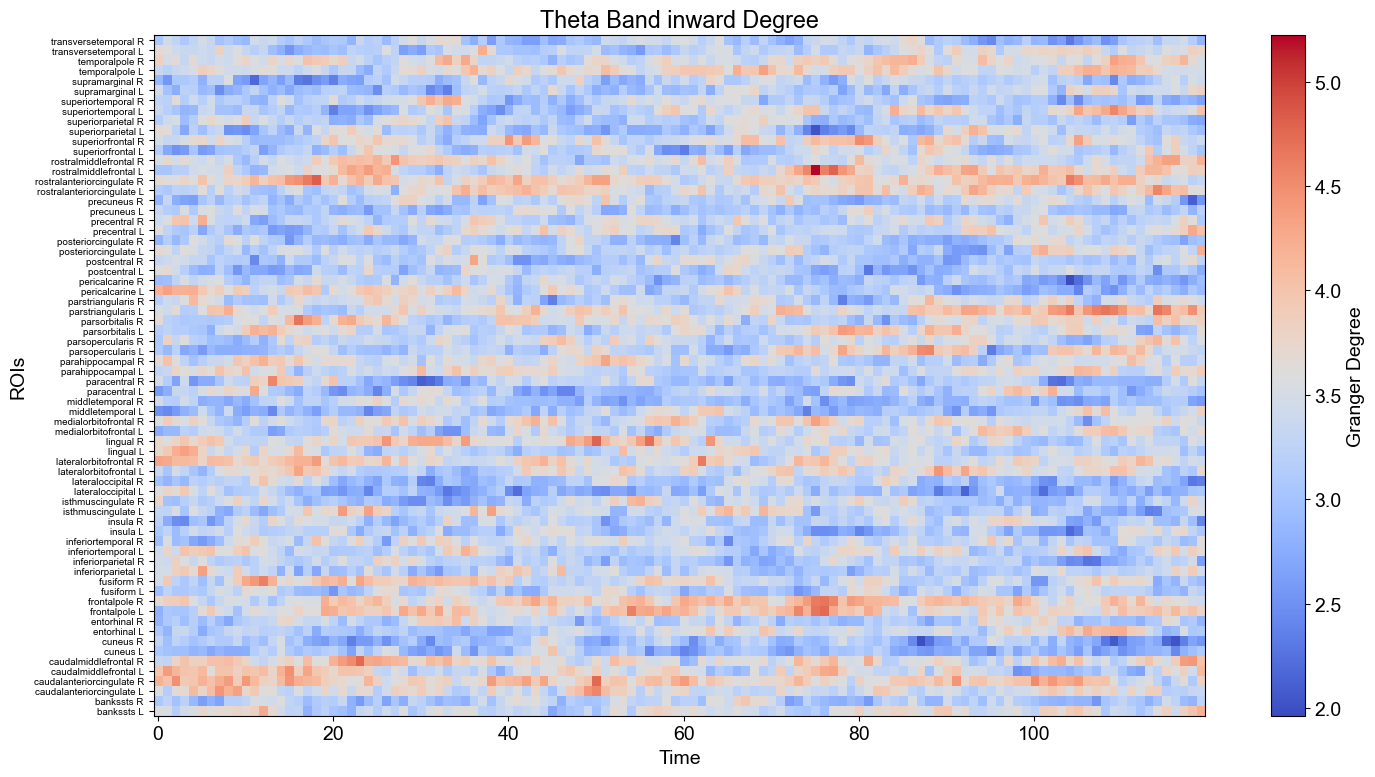

In [6]:
mat = np.mean(inward_deg_theta, axis = 1)

# Plot the masked raster
plt.figure(figsize=(15, 8))
plt.imshow(mat, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Granger Degree')
plt.xlabel('Time')
plt.ylabel('ROIs')
plt.yticks(ticks=np.arange(68), labels=labels, fontsize=7)
plt.title('Theta Band inward Degree')

plt.tight_layout()
plt.show()

In [6]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

list_indices_GM = list_indices.copy()

for index in [27,10]:
    del list_indices_GM[index]

indices_GM = []
for idx, (_, num_str) in enumerate(list_indices_GM):
    nums = [int(x.strip()) for x in num_str.split(',')]
    indices_GM.append(nums)

In [7]:
selected_fooof_list, not_selected_fooof_list = [], []
selected_degree_inward_theta, not_selected_degree_inward_theta = [], []
selected_degree_outward_theta, not_selected_degree_outward_theta = [], []
selected_degree_inward_delta, not_selected_degree_inward_delta = [], []
selected_degree_outward_delta, not_selected_degree_outward_delta = [], []
# Iterate over the list_of_lists
for idx in range(len(indices_GM)):
    # Select matrix[list_of_lists[idx], idx, :]
    selected_fooof = fooof_matrix[indices_GM[idx], idx, :]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    mask = ~np.isin(range(fooof_matrix.shape[0]), indices_GM[idx])
    not_selected_fooof = fooof_matrix[mask, idx, :]

    selected_inward_theta = inward_deg_theta[indices_GM[idx], idx, :]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    not_selected_inward_theta = inward_deg_theta[mask, idx, :]

    selected_inward_delta = inward_deg_delta[indices_GM[idx], idx, :]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    not_selected_inward_delta = inward_deg_delta[mask, idx, :]

    selected_outward_theta = outward_deg_theta[indices_GM[idx], idx, :]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    not_selected_outward_theta = outward_deg_theta[mask, idx, :]

    selected_outward_delta = outward_deg_delta[indices_GM[idx], idx, :]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    not_selected_outward_delta = outward_deg_delta[mask, idx, :]

    selected_fooof_list.append(selected_fooof)
    not_selected_fooof_list.append(not_selected_fooof)

    selected_degree_inward_theta.append(selected_inward_theta)
    not_selected_degree_inward_theta.append(not_selected_inward_theta)

    selected_degree_outward_theta.append(selected_outward_theta)
    not_selected_degree_outward_theta.append(not_selected_outward_theta)

    selected_degree_inward_delta.append(selected_inward_delta)
    not_selected_degree_inward_delta.append(not_selected_inward_delta)

    selected_degree_outward_delta.append(selected_outward_delta)
    not_selected_degree_outward_delta.append(not_selected_outward_delta)

In [8]:
# Helper to compute mean, std, and standard error
def compute_avg_std_se(nested_list):
    flat = [nested_list[i][j] for i in range(len(nested_list)) for j in range(len(nested_list[i]))]
    data = np.stack(flat)
    avg = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=1)
    se = std / np.sqrt(data.shape[0])
    return avg, std, se


In [9]:
selected_fooof = np.mean([selected_fooof_list[i][j] for i in range(len(selected_fooof_list)) for j in range(len(selected_fooof_list[i]))], axis = 0)
not_selected_fooof = np.mean([not_selected_fooof_list[i][j] for i in range(len(not_selected_fooof_list)) for j in range(len(not_selected_fooof_list[i]))], axis = 0)

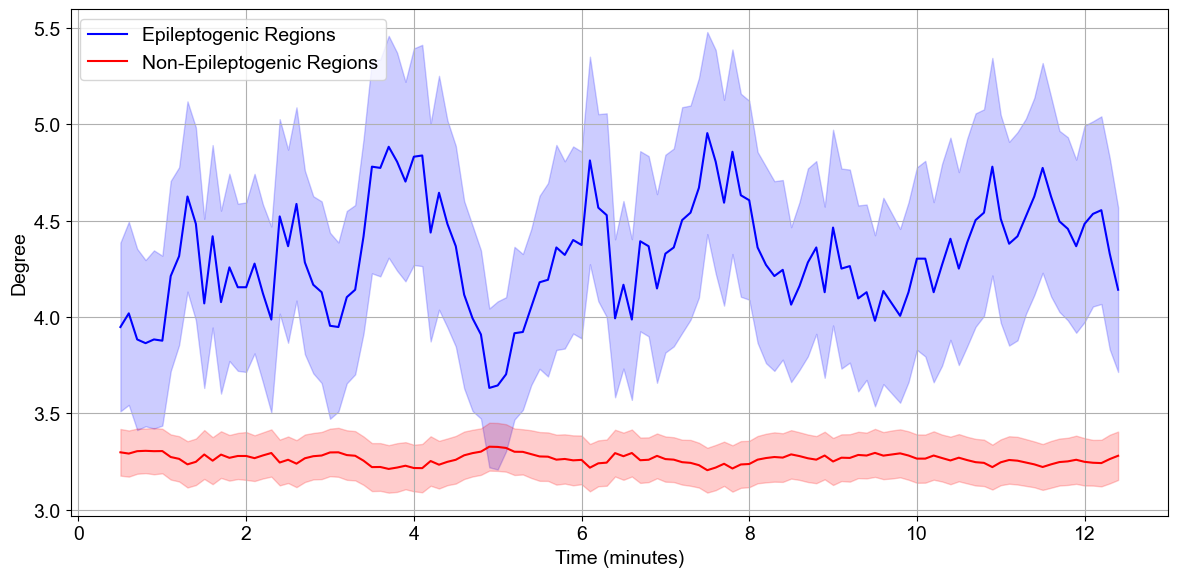

In [10]:
avg_selected_degree_outward_theta,_,se_selected_degree_outward_theta = compute_avg_std_se(selected_degree_outward_theta)

avg_not_selected_degree_outward_theta,_,se_not_selected_degree_outward_theta = compute_avg_std_se(not_selected_degree_outward_theta)

# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]


plt.figure(figsize=(12, 6))
x = window_center_times_min
plt.plot(x, avg_selected_degree_outward_theta, label='Epileptogenic Regions', color='blue')
plt.plot(x, avg_not_selected_degree_outward_theta, label='Non-Epileptogenic Regions', color='red')

plt.fill_between(x,
                 avg_selected_degree_outward_theta - se_selected_degree_outward_theta,
                 avg_selected_degree_outward_theta + se_selected_degree_outward_theta,
                 color='blue', alpha=0.2)

plt.fill_between(x,
                 avg_not_selected_degree_outward_theta - se_not_selected_degree_outward_theta,
                 avg_not_selected_degree_outward_theta + se_not_selected_degree_outward_theta,
                 color='red', alpha=0.2)

# Labels and legend
plt.xlabel('Time (minutes)')
plt.ylabel('Degree')
#plt.title('Theta Band Outward Connections')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\Theta Band Outward Degree.png", dpi=700) 

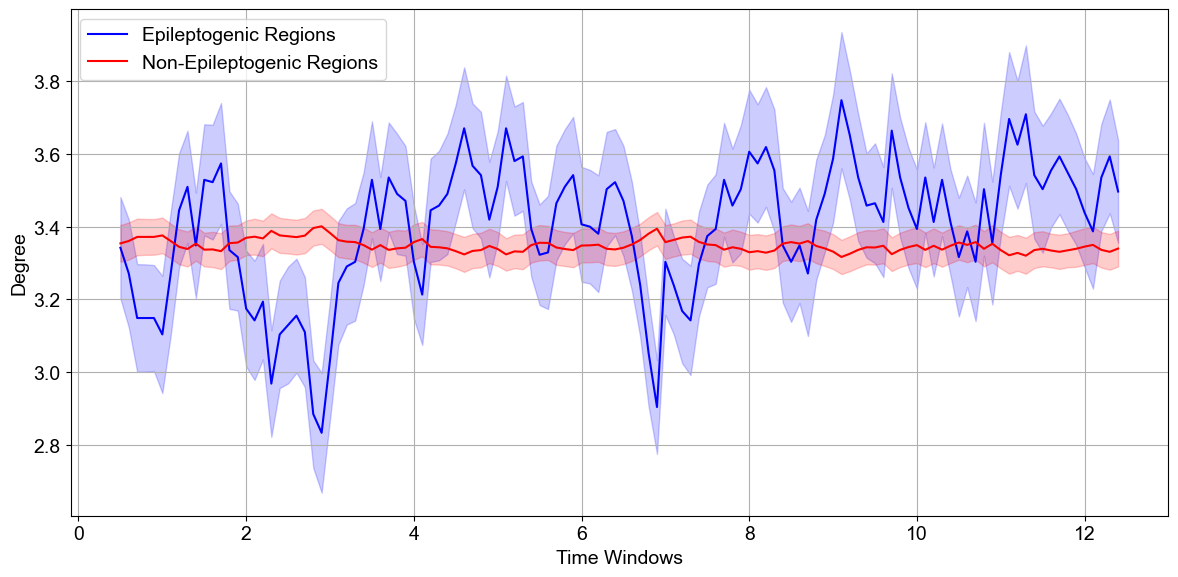

In [11]:
avg_selected_degree_inward_theta ,_, se_selected_degree_inward_theta = compute_avg_std_se(selected_degree_inward_theta)
avg_not_selected_degree_inward_theta ,_, se_not_selected_degree_inward_theta = compute_avg_std_se(not_selected_degree_inward_theta) 

# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

plt.figure(figsize=(12, 6))
x = window_center_times_min
plt.plot(x, avg_selected_degree_inward_theta, label='Epileptogenic Regions', color='blue')
plt.plot(x, avg_not_selected_degree_inward_theta, label='Non-Epileptogenic Regions', color='red')

plt.fill_between(x,
                 avg_selected_degree_inward_theta - se_selected_degree_inward_theta,
                 avg_selected_degree_inward_theta + se_selected_degree_inward_theta,
                 color='blue', alpha=0.2)

plt.fill_between(x,
                 avg_not_selected_degree_inward_theta - se_not_selected_degree_inward_theta,
                 avg_not_selected_degree_inward_theta + se_not_selected_degree_inward_theta,
                 color='red', alpha=0.2)


# Labels and legend
plt.xlabel('Time Windows')
plt.ylabel('Degree')
#plt.title('Theta Band Inward Connections')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\Theta Band Inward Degree.png", dpi=700) 

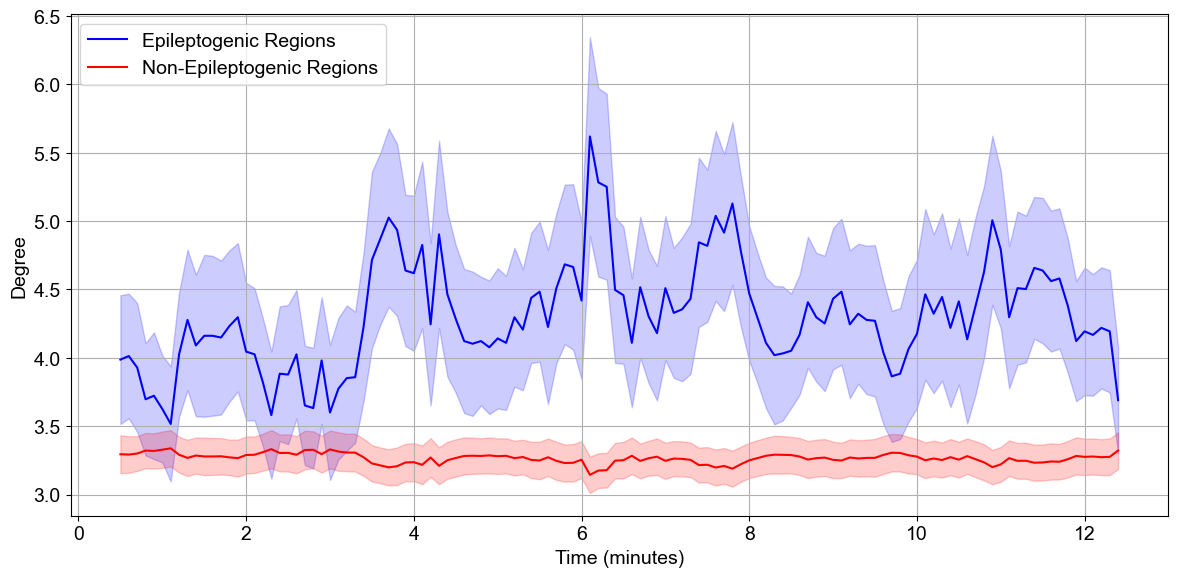

In [14]:
avg_selected_degree_outward_delta ,_, se_selected_degree_outward_delta = compute_avg_std_se(selected_degree_outward_delta)
avg_not_selected_degree_outward_delta ,_, se_not_selected_degree_outward_delta = compute_avg_std_se(not_selected_degree_outward_delta)


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]


plt.figure(figsize=(12, 6))
x = window_center_times_min
plt.plot(x, avg_selected_degree_outward_delta, label='Epileptogenic Regions', color='blue')
plt.plot(x, avg_not_selected_degree_outward_delta, label='Non-Epileptogenic Regions', color='red')



plt.fill_between(x,
                 avg_selected_degree_outward_delta - se_selected_degree_outward_delta,
                 avg_selected_degree_outward_delta + se_selected_degree_outward_delta,
                 color='blue', alpha=0.2)

plt.fill_between(x,
                 avg_not_selected_degree_outward_delta - se_not_selected_degree_outward_delta,
                 avg_not_selected_degree_outward_delta + se_not_selected_degree_outward_delta,
                 color='red', alpha=0.2)


# Labels and legend
plt.xlabel('Time (minutes)')
plt.ylabel('Degree')
#plt.title('Theta Band Outward Connections')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 2\\Delta Band Outward Degree.png", dpi=700) 

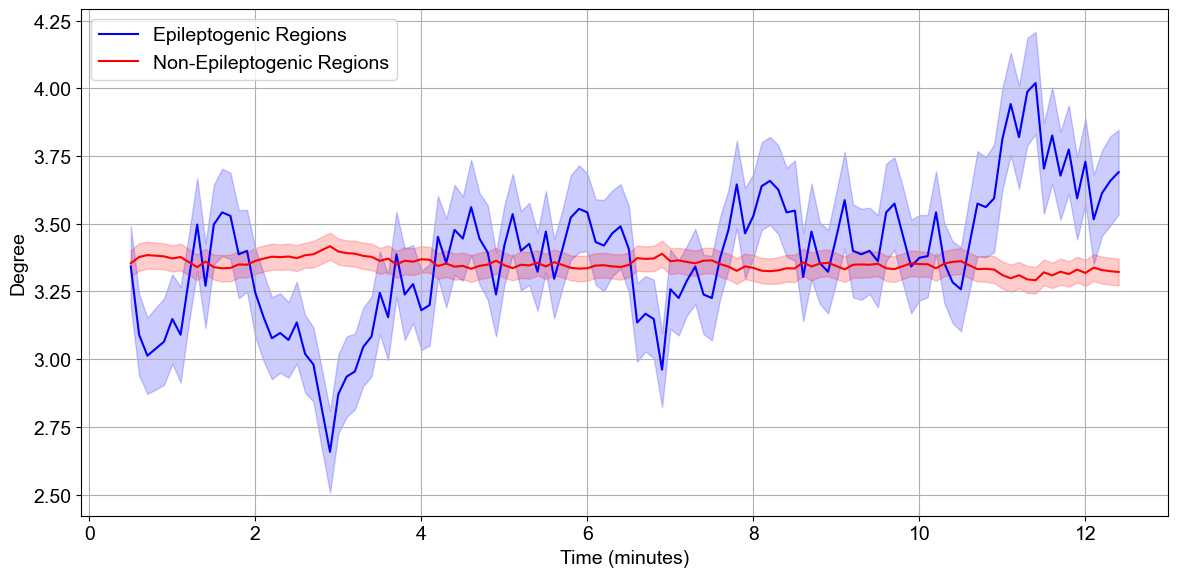

In [17]:
avg_selected_degree_inward_delta ,_, se_selected_degree_inward_delta = compute_avg_std_se(selected_degree_inward_delta)
avg_not_selected_degree_inward_delta ,_, se_not_selected_degree_inward_delta = compute_avg_std_se(not_selected_degree_inward_delta)


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]


plt.figure(figsize=(12, 6))
x = window_center_times_min
plt.plot(x, avg_selected_degree_inward_delta, label='Epileptogenic Regions', color='blue')
plt.plot(x, avg_not_selected_degree_inward_delta, label='Non-Epileptogenic Regions', color='red')

plt.fill_between(x,
                 avg_selected_degree_inward_delta - se_selected_degree_inward_delta,
                 avg_selected_degree_inward_delta + se_selected_degree_inward_delta,
                 color='blue', alpha=0.2)

plt.fill_between(x,
                 avg_not_selected_degree_inward_delta - se_not_selected_degree_inward_delta,
                 avg_not_selected_degree_inward_delta + se_not_selected_degree_inward_delta,
                 color='red', alpha=0.2)

# Labels and legend
plt.xlabel('Time (minutes)')
plt.ylabel('Degree')
#plt.title('Theta Band Inward Connections')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 2\\Delta Band Inward Degree.png", dpi=700) 

#### CORRELATION IN TIME BETWEEN FOOOF exp and CONNECTIVITY DEGREE INWARD AND OUTWARD ####

In [18]:
selected_fooof_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in selected_fooof_list])
not_selected_fooof_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in not_selected_fooof_list])

selected_degree_inward_theta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in selected_degree_inward_theta])
not_selected_degree_inward_theta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in not_selected_degree_inward_theta])

selected_degree_outward_theta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in selected_degree_outward_theta])
not_selected_degree_outward_theta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in not_selected_degree_outward_theta])

selected_degree_inward_delta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in selected_degree_inward_delta])
not_selected_degree_inward_delta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in not_selected_degree_inward_delta])

selected_degree_outward_delta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in selected_degree_outward_delta])
not_selected_degree_outward_delta_27x120 = np.array([np.mean(np.array(subject_data), axis=0) for subject_data in not_selected_degree_outward_delta])

In [19]:
fooof_inward_degree_theta_epi_corr, fooof_inward_degree_theta_epi_pval  = zip(*[spearmanr(selected_fooof_27x120[:, i], selected_degree_inward_theta_27x120[:, i]) for i in range(120)])
fooof_inward_degree_theta_nonepi_corr, fooof_inward_degree_theta_nonepi_pval  = zip(*[spearmanr(not_selected_fooof_27x120[:, i], not_selected_degree_inward_theta_27x120[:, i]) for i in range(120)])
fooof_outward_degree_theta_epi_corr, fooof_outward_degree_theta_epi_pval  = zip(*[spearmanr(selected_fooof_27x120[:, i], selected_degree_outward_theta_27x120[:, i]) for i in range(120)])
fooof_outward_degree_theta_nonepi_corr, fooof_outward_degree_theta_nonepi_pval  = zip(*[spearmanr(not_selected_fooof_27x120[:, i], not_selected_degree_outward_theta_27x120[:, i]) for i in range(120)])

fooof_inward_degree_delta_epi_corr, fooof_inward_degree_delta_epi_pval  = zip(*[spearmanr(selected_fooof_27x120[:, i], selected_degree_inward_delta_27x120[:, i]) for i in range(120)])
fooof_inward_degree_delta_nonepi_corr, fooof_inward_degree_delta_nonepi_pval  = zip(*[spearmanr(not_selected_fooof_27x120[:, i], not_selected_degree_inward_delta_27x120[:, i]) for i in range(120)])
fooof_outward_degree_delta_epi_corr, fooof_outward_degree_delta_epi_pval  = zip(*[spearmanr(selected_fooof_27x120[:, i], selected_degree_outward_delta_27x120[:, i]) for i in range(120)])
fooof_outward_degree_delta_nonepi_corr, fooof_outward_degree_delta_nonepi_pval  = zip(*[spearmanr(not_selected_fooof_27x120[:, i], not_selected_degree_outward_delta_27x120[:, i]) for i in range(120)])

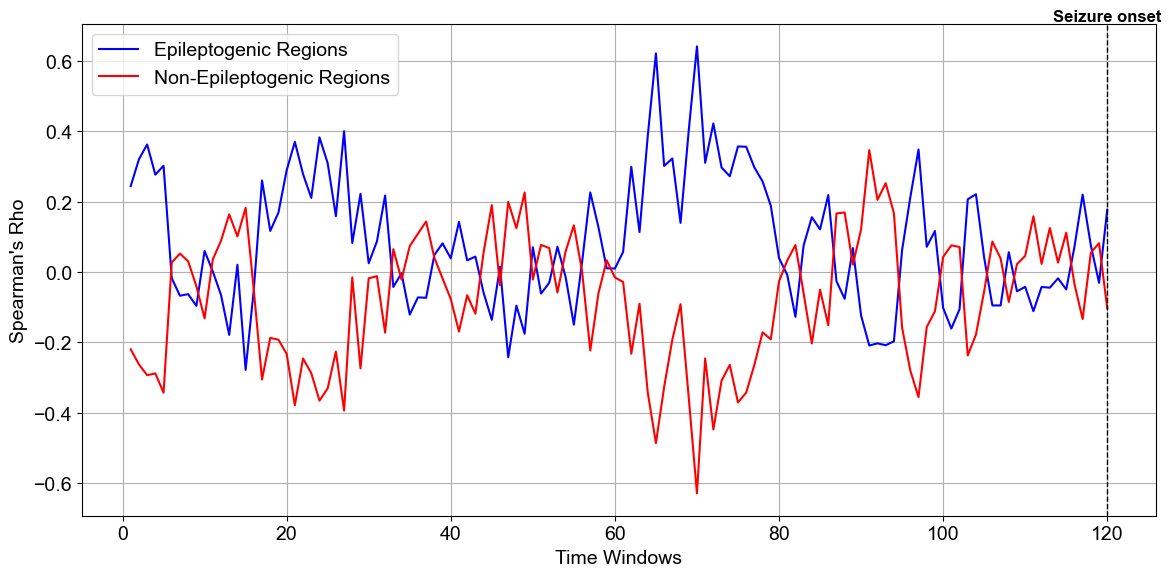

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,121), fooof_inward_degree_delta_epi_corr, label='Epileptogenic Regions', color='blue')
plt.plot(np.arange(1,121), fooof_inward_degree_delta_nonepi_corr, label='Non-Epileptogenic Regions', color='red')

# Labels and legend
plt.xlabel('Time Windows')
plt.ylabel("Spearman's Rho")
#plt.title('Spearman Correlation between delta Inward Degree Connectivity and FOOOF in time')

# Add vertical black line at x=120 with label
plt.axvline(x=120, color='black', linestyle='--', linewidth=1)
# Add label on top of the line
ymin, ymax = plt.ylim()
plt.text(120, ymax, "Seizure onset", color='black',
        ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\fontsize 14\\Rho FOOOF exp - inward degree delta.png", dpi=700) 


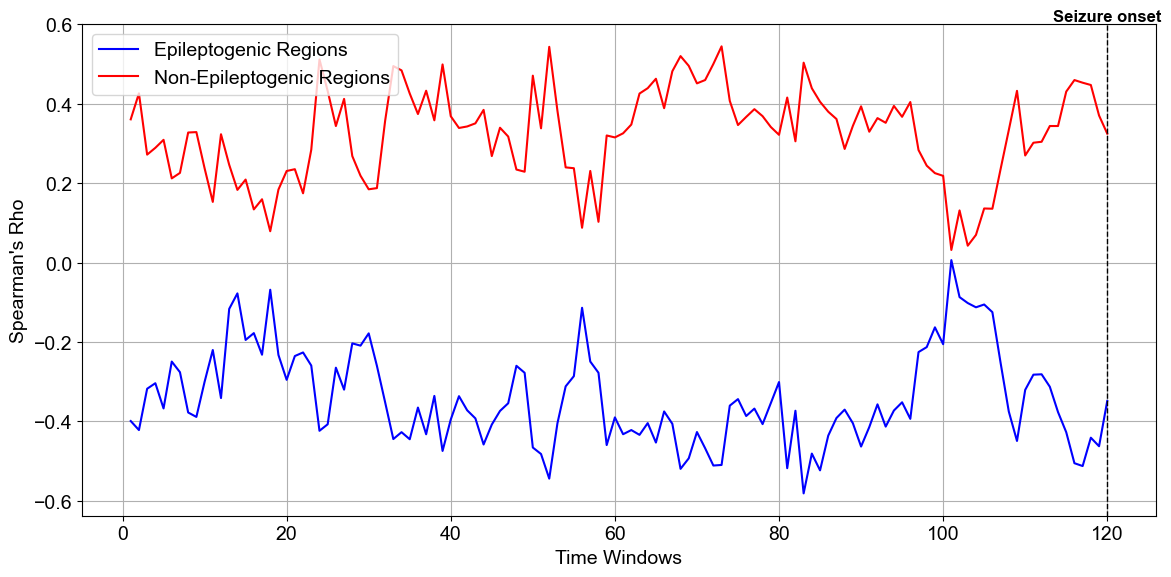

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,121), fooof_outward_degree_delta_epi_corr, label='Epileptogenic Regions', color='blue')
plt.plot(np.arange(1,121), fooof_outward_degree_delta_nonepi_corr, label='Non-Epileptogenic Regions', color='red')

# Labels and legend
plt.xlabel('Time Windows')
plt.ylabel("Spearman's Rho")
#plt.title('Spearman Correlation between delta Outward Degree Connectivity and FOOOF in time')
# Add vertical black line at x=120 with label
plt.axvline(x=120, color='black', linestyle='--', linewidth=1)
# Add label on top of the line
ymin, ymax = plt.ylim()
plt.text(120, ymax, "Seizure onset", color='black',
        ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\fontsize 14\\Rho FOOOF exp - outward degree delta.png",  dpi=700) 

### BOXPLOT DEGREE AND CORRELATIONS RESTING STATE AND PREICTAL DELTA BAND

#### average boxplot DELTA

In [74]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
resting_state_boxplot_data = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']


keys = [resting_state_boxplot_data[0][i][0] for i in range(len(resting_state_boxplot_data[0]))]
new_keys = ["Resting Epi Inward", "Resting Non-Epi Inward", "Resting Epi Outward", "Resting Non-Epi Outward"]
values = [resting_state_boxplot_data[1][i].flatten() for i in range(len(resting_state_boxplot_data[0]))][0:4]
rs_boxplot_dict = dict(zip(new_keys, values))
data_series = {key: pd.Series(value) for key, value in rs_boxplot_dict.items()}
resting_state_boxplot_data_df = pd.DataFrame(data_series)
del rs_boxplot_dict; del data_series

In [75]:
epi_preictal_inward_delta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_inward_delta]
nonepi_preictal_inward_delta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_inward_delta]
epi_preictal_outward_delta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_outward_delta]
nonepi_preictal_outward_delta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_outward_delta]

In [76]:
preict_keys = ["Pre-ictal Epi Inward", "Pre-ictal Non-Epi Inward", "Pre-ictal Epi Outward", "Pre-ictal Non-Epi Outward"]
preict_values = [epi_preictal_inward_delta, nonepi_preictal_inward_delta, epi_preictal_outward_delta, nonepi_preictal_outward_delta]

preictal_boxplot_dict = dict(zip(preict_keys, preict_values))
data_series = {key: pd.Series(value) for key, value in preictal_boxplot_dict.items()}
preictal_boxplot_data_df = pd.DataFrame(data_series)
del preictal_boxplot_dict; del data_series
preict_keys = ["Pre-ictal Epi Inward", "Pre-ictal Non-Epi Inward", "Pre-ictal Epi Outward", "Pre-ictal Non-Epi Outward"]
preict_values = [epi_preictal_inward_delta, nonepi_preictal_inward_delta, epi_preictal_outward_delta, nonepi_preictal_outward_delta]

preictal_boxplot_dict = dict(zip(preict_keys, preict_values))
data_series = {key: pd.Series(value) for key, value in preictal_boxplot_dict.items()}
preictal_boxplot_data_df = pd.DataFrame(data_series)
del preictal_boxplot_dict; del data_series

In [77]:
boxplot_final_df = pd.concat([resting_state_boxplot_data_df, preictal_boxplot_data_df], axis=1)

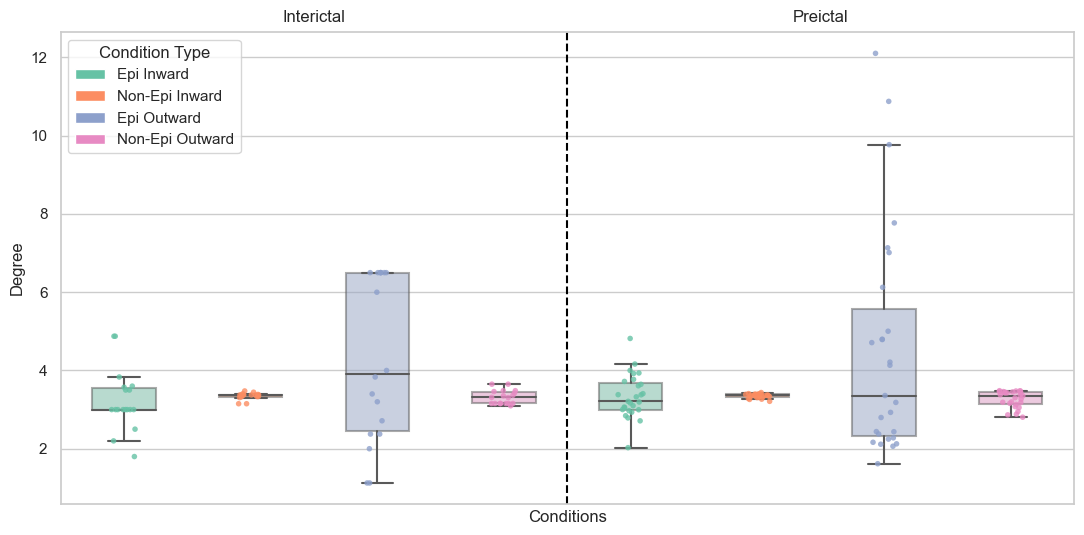

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Prepare long-form DataFrame
df_long = boxplot_final_df.melt(var_name='Condition', value_name='Degree')

# Set your desired order
condition_order = [
    'Resting Epi Inward', 'Resting Non-Epi Inward', 'Resting Epi Outward', 'Resting Non-Epi Outward',
    'Pre-ictal Epi Inward', 'Pre-ictal Non-Epi Inward', 'Pre-ictal Epi Outward', 'Pre-ictal Non-Epi Outward'
]

# Make sure the order is respected
df_long['Condition'] = pd.Categorical(df_long['Condition'], categories=condition_order, ordered=True)

# Color setup
base_colors = sns.color_palette("Set2", n_colors=4)
condition_types = ['Epi Inward', 'Non-Epi Inward', 'Epi Outward', 'Non-Epi Outward']
color_map = dict(zip(condition_types, base_colors))

# Map each condition to a color
def assign_color(cond):
    if "Inward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Inward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Inward']
    elif "Outward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Outward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Outward']
    return 'gray'

colors = [assign_color(c) for c in condition_order]

# Create figure
plt.figure(figsize=(11, 5.5))

# Draw boxplot with color per condition
sns.boxplot(data=df_long, x='Condition', y='Degree', palette=colors, width=0.5, boxprops=dict(alpha=0.5), showcaps=True, whiskerprops={'linewidth': 1.5}, fliersize=0)

# Overlay stripplot
sns.stripplot(data=df_long, x='Condition', y='Degree', palette=colors, jitter=True, size=4, alpha=0.8)

# Add vertical line between RS and Pre-Ictal
plt.axvline(3.5, color='black', linestyle='--')

# Add custom section labels
plt.text(1.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Interictal', ha='center')
plt.text(5.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Preictal', ha='center')
plt.xticks([],[])
# Custom legend
legend_elements = [Patch(facecolor=col, label=lbl) for col, lbl in zip(base_colors, condition_types)]
plt.legend(handles=legend_elements, title='Condition Type', loc='upper left', frameon=True)

plt.xlabel("Conditions")
plt.ylabel("Degree")
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 2\\Boxplot connectivity.png", dpi=700) 

In [79]:
from scipy.stats import ttest_ind
import itertools

results = []

# Generate all unique column pairs
column_pairs = list(itertools.combinations(boxplot_final_df.columns, 2))

# Perform t-tests
for col1, col2 in column_pairs:
    data1 = boxplot_final_df[col1].dropna()
    data2 = boxplot_final_df[col2].dropna()
    t_stat, p_val = ttest_ind(data1, data2, equal_var=False)  # Welch’s t-test
    results.append({
        'Column 1': col1,
        'Column 2': col2,
        't-statistic': t_stat,
        'p-value': p_val
    })

# Convert to a DataFrame for easier viewing
t_test_results = pd.DataFrame(results)
significant_results = t_test_results[t_test_results['p-value'] < 0.05].reset_index(drop=True)

print(significant_results)

                   Column 1                   Column 2  t-statistic   p-value
0        Resting Epi Inward      Pre-ictal Epi Outward    -2.231755  0.032902
1    Resting Non-Epi Inward      Pre-ictal Epi Outward    -2.146448  0.041317
2       Resting Epi Outward  Pre-ictal Non-Epi Outward     2.116989  0.049098
3   Resting Non-Epi Outward      Pre-ictal Epi Outward    -2.201176  0.036695
4      Pre-ictal Epi Inward      Pre-ictal Epi Outward    -2.126704  0.042419
5  Pre-ictal Non-Epi Inward      Pre-ictal Epi Outward    -2.144525  0.041503
6     Pre-ictal Epi Outward  Pre-ictal Non-Epi Outward     2.290675  0.030244


#### average boxplot THETA

In [64]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
resting_state_boxplot_data = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']

keys = [resting_state_boxplot_data[0][i][0] for i in range(len(resting_state_boxplot_data[0]))]
new_keys = ["Resting Epi Inward THETA", "Resting Non-Epi Inward THETA", "Resting Epi Outward THETA", "Resting Non-Epi Outward THETA"]
values = [resting_state_boxplot_data[1][i].flatten() for i in range(len(resting_state_boxplot_data[0]))][4:]
rs_boxplot_dict = dict(zip(new_keys, values))
data_series = {key: pd.Series(value) for key, value in rs_boxplot_dict.items()}
resting_state_boxplot_data_df_theta = pd.DataFrame(data_series)
del rs_boxplot_dict; del data_series

In [65]:
epi_preictal_inward_theta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_inward_theta]
nonepi_preictal_inward_theta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_inward_theta]
epi_preictal_outward_theta = [np.mean(subj, axis= (0,1)) for subj in selected_degree_outward_theta]
nonepi_preictal_outward_theta = [np.mean(subj, axis= (0,1)) for subj in not_selected_degree_outward_theta]

In [66]:
preict_keys = ["Pre-ictal Epi Inward THETA", "Pre-ictal Non-Epi Inward THETA", "Pre-ictal Epi Outward THETA", "Pre-ictal Non-Epi Outward THETA"]
preict_values = [epi_preictal_inward_theta, nonepi_preictal_inward_theta, epi_preictal_outward_theta, nonepi_preictal_outward_theta]

preictal_boxplot_dict = dict(zip(preict_keys, preict_values))
data_series = {key: pd.Series(value) for key, value in preictal_boxplot_dict.items()}
preictal_boxplot_data_df_theta = pd.DataFrame(data_series)
del preictal_boxplot_dict; del data_series

In [67]:
boxplot_final_df_theta = pd.concat([resting_state_boxplot_data_df_theta, preictal_boxplot_data_df_theta], axis=1)

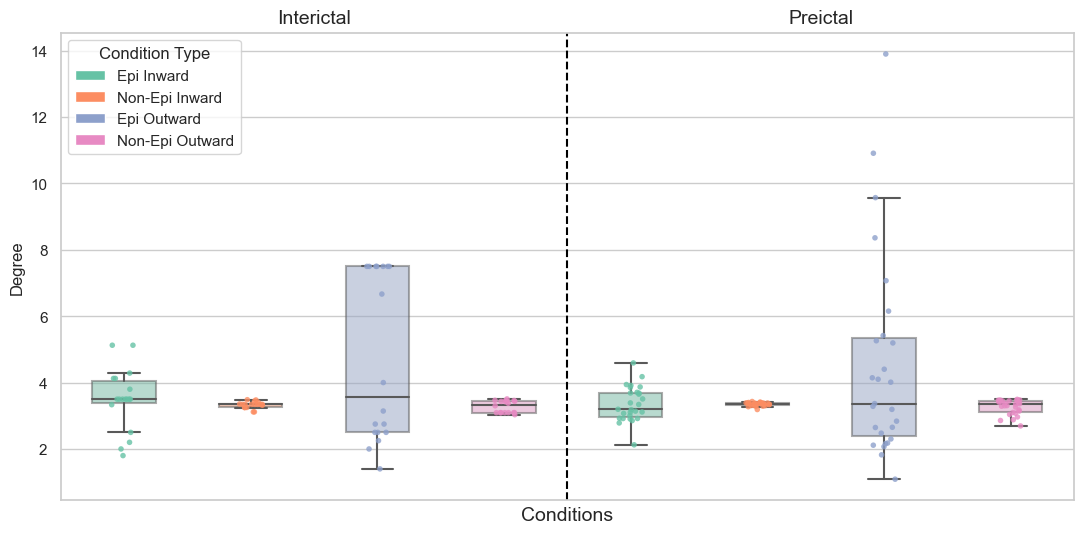

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Prepare long-form DataFrame
df_long = boxplot_final_df_theta.melt(var_name='Condition', value_name='Degree')

# Set your desired order
condition_order = [
    'Resting Epi Inward THETA', 'Resting Non-Epi Inward THETA', 'Resting Epi Outward THETA', 'Resting Non-Epi Outward THETA',
    'Pre-ictal Epi Inward THETA', 'Pre-ictal Non-Epi Inward THETA', 'Pre-ictal Epi Outward THETA', 'Pre-ictal Non-Epi Outward THETA'
]

# Make sure the order is respected
df_long['Condition'] = pd.Categorical(df_long['Condition'], categories=condition_order, ordered=True)

# Color setup
base_colors = sns.color_palette("Set2", n_colors=4)
condition_types = ['Epi Inward', 'Non-Epi Inward', 'Epi Outward', 'Non-Epi Outward']
color_map = dict(zip(condition_types, base_colors))

# Map each condition to a color
def assign_color(cond):
    if "Inward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Inward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Inward']
    elif "Outward" in cond:
        if "Epi" in cond and "Non" not in cond:
            return color_map['Epi Outward']
        elif "Non-Epi" in cond:
            return color_map['Non-Epi Outward']
    return 'gray'

colors = [assign_color(c) for c in condition_order]

# Create figure
plt.figure(figsize=(11, 5.5))

# Draw boxplot with color per condition
sns.boxplot(data=df_long, x='Condition', y='Degree', palette=colors, width=0.5, boxprops=dict(alpha=0.5), showcaps=True, whiskerprops={'linewidth': 1.5}, fliersize=0)

# Overlay stripplot
sns.stripplot(data=df_long, x='Condition', y='Degree', palette=colors, jitter=True, size=4, alpha=0.8)

# Add vertical line between RS and Pre-Ictal
plt.axvline(3.5, color='black', linestyle='--')

# Add custom section labels
plt.text(1.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Interictal', ha='center', fontsize=14)
plt.text(5.5, plt.ylim()[1] + 0.02 * plt.ylim()[1], 'Preictal', ha='center', fontsize=14)
plt.xticks([],[])
# Custom legend
legend_elements = [Patch(facecolor=col, label=lbl) for col, lbl in zip(base_colors, condition_types)]
plt.legend(handles=legend_elements, title='Condition Type', loc='upper left', frameon=True)

plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Degree")
plt.tight_layout()
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\Boxplot connectivity Theta Band.png", dpi=700) 

In [44]:
from scipy.stats import ttest_ind
import itertools

results = []

# Generate all unique column pairs
column_pairs = list(itertools.combinations(boxplot_final_df_theta.columns, 2))

# Perform t-tests
for col1, col2 in column_pairs:
    data1 = boxplot_final_df_theta[col1].dropna()
    data2 = boxplot_final_df_theta[col2].dropna()
    t_stat, p_val = ttest_ind(data1, data2, equal_var=False)  # Welch’s t-test
    results.append({
        'Column 1': col1,
        'Column 2': col2,
        't-statistic': t_stat,
        'p-value': p_val
    })

# Convert to a DataFrame for easier viewing
t_test_results = pd.DataFrame(results)
significant_results = t_test_results[t_test_results['p-value'] < 0.05].reset_index(drop=True)

print(significant_results)

                        Column 1                         Column 2  \
0   Resting Non-Epi Inward THETA        Resting Epi Outward THETA   
1   Resting Non-Epi Inward THETA      Pre-ictal Epi Outward THETA   
2      Resting Epi Outward THETA    Resting Non-Epi Outward THETA   
3      Resting Epi Outward THETA       Pre-ictal Epi Inward THETA   
4      Resting Epi Outward THETA   Pre-ictal Non-Epi Inward THETA   
5      Resting Epi Outward THETA  Pre-ictal Non-Epi Outward THETA   
6  Resting Non-Epi Outward THETA      Pre-ictal Epi Outward THETA   
7    Pre-ictal Epi Outward THETA  Pre-ictal Non-Epi Outward THETA   

   t-statistic   p-value  
0    -2.344843  0.031391  
1    -2.055491  0.049970  
2     2.422405  0.026752  
3     2.268403  0.035858  
4     2.309194  0.033754  
5     2.443667  0.025617  
6    -2.133819  0.042356  
7     2.155159  0.040486  


#### PREICTAL BARPLOT

In [17]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
corr_degree_exp_resting = scipy.io.loadmat(path + "Correlation_granger_exp_rest.mat")['Corr_GC_exp_res']

columns = [col[0] for col in corr_degree_exp_resting[0]][1:]
rho = [r[0] for r in corr_degree_exp_resting[1]][1:]
pvals = [p[0] for p in corr_degree_exp_resting[2]][1:]

corr_degree_exp_resting_df = pd.DataFrame([rho, pvals], columns=columns)

In [18]:
avg_fooof_epi, avg_fooof_nonepi = [np.mean(subj, axis=(0,1)) for subj in selected_fooof_list], [np.mean(subj, axis=(0,1)) for subj in not_selected_fooof_list]
avg_epi_degree_inward_theta, avg_nonepi_degree_inward_theta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_inward_theta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_inward_theta]
avg_epi_degree_outward_theta, avg_nonepi_degree_outward_theta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_outward_theta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_outward_theta]
avg_epi_degree_inward_delta, avg_nonepi_degree_inward_delta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_inward_delta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_inward_delta]
avg_epi_degree_outward_delta, avg_nonepi_degree_outward_delta = [np.mean(subj, axis=(0,1)) for subj in selected_degree_outward_delta], [np.mean(subj, axis=(0,1)) for subj in not_selected_degree_outward_delta]

In [19]:
corr_fooof_outward_theta_epi, pval_fooof_outward_theta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_outward_theta)
corr_fooof_outward_theta_nonepi, pval_fooof_outward_theta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_outward_theta)

corr_fooof_inward_theta_epi, pval_fooof_inward_theta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_inward_theta)
corr_fooof_inward_theta_nonepi, pval_fooof_inward_theta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_inward_theta)

corr_fooof_outward_delta_epi, pval_fooof_outward_delta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_outward_delta)
corr_fooof_outward_delta_nonepi, pval_fooof_outward_delta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_outward_delta)

corr_fooof_inward_delta_epi, pval_fooof_inward_delta_epi = spearmanr(avg_fooof_epi, avg_epi_degree_inward_delta)
corr_fooof_inward_delta_nonepi, pval_fooof_inward_delta_nonepi = spearmanr(avg_fooof_nonepi, avg_nonepi_degree_inward_delta)

#### INTERICTAL STATE BARPLOT

In [45]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting\\resting_fooof.pkl", 'rb') as file:
    fooof_resting = pickle.load(file)

In [46]:
desired_order = ['SJ_10', 
                 'SJ_103',
                'SJ_107',
                'SJ_111',
                'SJ_115',
                'SJ_159',
                'SJ_176',
                'SJ_185',
                'SJ_205',
                'SJ_39',
                'SJ_46',
                'SJ_47',
                'SJ_60',
                'SJ_63',
                'SJ_64',
                'SJ_67',
                'SJ_68',
                'SJ_83']

reordered_fooof_resting = {key: fooof_resting[key] for key in desired_order}

fooof_resting_list = np.array([values for keys,values in reordered_fooof_resting.items()])
avg_time_fooof_resting = np.mean(fooof_resting_list, axis = 2)

In [47]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

list_indices_resting = [(key.split('_sz')[0], value) for key, value in list_indices]
list_indices_resting = natsorted(tuple(set(list_indices_resting)))

# removing 2 subjects that are not in the fooof exp interictal data
for index in [18,10]:
    del list_indices_resting[index]

list_indices_resting = [(k, [int(x) for x in v.split(',')]) for k, v in list_indices_resting]


In [48]:
epi_fooof_list_resting, nonepi_fooof_list_resting = [], []

# Iterate over the list_of_lists
for idx in range(len(list_indices_resting)):
    # Select matrix[list_of_lists[idx], idx, :]
    selected_fooof = avg_time_fooof_resting[idx, list_indices_resting[idx][1]]
    # Select all rows except those in list_of_lists[idx]
    # Using np.isin to create a boolean mask that excludes the rows in list_of_lists[idx]
    mask = np.arange(0,68)
    mask = ~np.isin(mask, list_indices_resting[idx])
    not_selected_fooof = avg_time_fooof_resting[idx, mask]

    epi_fooof_list_resting.append(selected_fooof)
    nonepi_fooof_list_resting.append(not_selected_fooof)

c:\Users\simon\anaconda3\envs\mne\lib\site-packages\numpy\lib\arraysetops.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar2 = np.asarray(ar2).ravel()


In [49]:
epi_fooof_list_resting = np.array([np.mean(subj) for subj in epi_fooof_list_resting])
nonepi_fooof_list_resting = np.array([np.mean(subj) for subj in nonepi_fooof_list_resting])


In [50]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
granger_resting = scipy.io.loadmat(path + "GC_resting_per_boxplot_avg_per_sj.mat")['GC_res_Epi_nEPI_avg_per_sj']

keys = [resting_state_boxplot_data[0][i][0] for i in range(len(resting_state_boxplot_data[0]))]
new_keys = ["Resting Epi Inward", "Resting Non-Epi Inward", "Resting Epi Outward", "Resting Non-Epi Outward", "Resting Epi Inward theta", "Resting Non-Epi Inward theta", "Resting Epi Outward theta" , "Resting Non-Epi Outward theta"]
values = [resting_state_boxplot_data[1][i].flatten() for i in range(len(resting_state_boxplot_data[0]))]
rs_boxplot_dict = dict(zip(new_keys, values))
data_series = {key: pd.Series(value) for key, value in rs_boxplot_dict.items()}
granger_resting_df = pd.DataFrame(data_series)
del rs_boxplot_dict; del data_series

In [51]:
corr_fooof_outward_theta_epi_resting, pval_fooof_outward_theta_epi_resting = spearmanr(epi_fooof_list_resting, granger_resting_df['Resting Epi Outward theta'])
corr_fooof_outward_theta_nonepi_resting, pval_fooof_outward_theta_nonepi_resting = spearmanr(nonepi_fooof_list_resting, granger_resting_df["Resting Non-Epi Outward theta"]
)

corr_fooof_inward_theta_epi_resting, pval_fooof_inward_theta_epi_resting = spearmanr(epi_fooof_list_resting, granger_resting_df['Resting Epi Inward theta'])
corr_fooof_inward_theta_nonepi_resting, pval_fooof_inward_theta_nonepi_resting = spearmanr(nonepi_fooof_list_resting, granger_resting_df['Resting Non-Epi Inward theta'])

corr_fooof_outward_delta_epi_resting, pval_fooof_outward_delta_epi_resting = spearmanr(epi_fooof_list_resting, granger_resting_df['Resting Epi Outward'])
corr_fooof_outward_delta_nonepi_resting, pval_fooof_outward_delta_nonepi_resting = spearmanr(nonepi_fooof_list_resting, granger_resting_df['Resting Non-Epi Outward'])

corr_fooof_inward_delta_epi_resting, pval_fooof_inward_delta_epi_resting = spearmanr(epi_fooof_list_resting, granger_resting_df['Resting Epi Inward'])
corr_fooof_inward_delta_nonepi_resting, pval_fooof_inward_delta_nonepi_resting = spearmanr(nonepi_fooof_list_resting, granger_resting_df['Resting Non-Epi Inward'])

#### THETA BAND BARPLOT

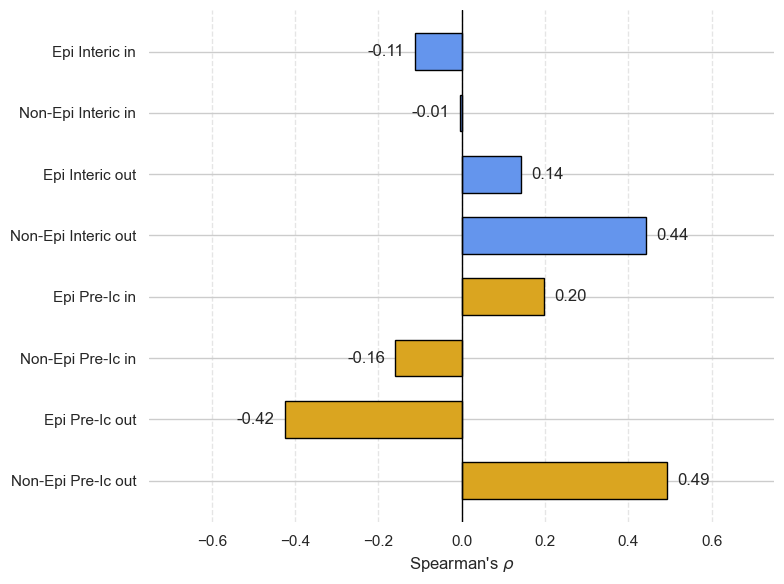

In [52]:
# Correlation values
correlations = [
    corr_fooof_inward_theta_epi_resting,
    corr_fooof_inward_theta_nonepi_resting,
    corr_fooof_outward_theta_epi_resting,
    corr_fooof_outward_theta_nonepi_resting,
    corr_fooof_inward_theta_epi,
    corr_fooof_inward_theta_nonepi,
    corr_fooof_outward_theta_epi,
    corr_fooof_outward_theta_nonepi
]

# Labels
labels = [
    "Epi Interic in",
    "Non-Epi Interic in",
    "Epi Interic out",
    "Non-Epi Interic out",
    "Epi Pre-Ic in",
    "Non-Epi Pre-Ic in",
    "Epi Pre-Ic out",
    "Non-Epi Pre-Ic out"
]

# Set Seaborn style for cleaner visuals
sns.set(style='whitegrid')

# Ensure values are floats
correlations = [float(c) for c in correlations]

# Colors: differentiate Resting vs Pre-Ictal
colors = ['goldenrod' if 'Pre-Ic' in lbl else 'cornflowerblue' for lbl in labels]

# Reverse order so first label appears at the top
correlations = correlations[::-1]
labels = labels[::-1]
colors = colors[::-1]

# Create plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, correlations, color=colors, edgecolor='black', height=0.6)

# Axis labels
plt.xlabel(r"Spearman's $\rho$")

# Grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Axis limits and ticks
plt.xlim(-0.75, 0.75)
plt.xticks()
plt.yticks()

# Annotate values with fixed offset from bar edge
offset = 0.025  # Fixed distance from bar edge

for bar in bars:
    value = bar.get_width()
    xpos = value + offset if value >= 0 else value - offset
    ha = 'left' if value >= 0 else 'right'
    plt.text(xpos, bar.get_y() + bar.get_height() / 2,
             f"{value:.2f}", va='center', ha=ha)

# Optional: add subtle divider line between RS and Pre-Ic
#plt.axhline(3.5, color='black', linestyle='--', linewidth=1, alpha=0.3)

# Remove spines
sns.despine(left=True, bottom=True)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\supplementari\\Barplot correlations THETA band.png", dpi=700) 

In [53]:
from mne.stats import fdr_correction
dict_pvalues_theta = {
    'fooof_outward_theta_epi_ic': pval_fooof_outward_theta_epi,
    'fooof_outward_theta_nonepi_ic': pval_fooof_outward_theta_nonepi,
    'fooof_inward_theta_epi_ic': pval_fooof_inward_theta_epi,
    'fooof_inward_theta_nonepi_ic': pval_fooof_inward_theta_nonepi

}

rejected, pvals_corrected_theta = fdr_correction(list(dict_pvalues_theta.values()), alpha=0.05)
list(zip(dict_pvalues_theta.keys(), pvals_corrected_theta))

[('fooof_outward_theta_epi_ic', 0.05479590166094679),
 ('fooof_outward_theta_nonepi_ic', 0.03612930562947177),
 ('fooof_inward_theta_epi_ic', 0.42726988049484715),
 ('fooof_inward_theta_nonepi_ic', 0.42726988049484715)]

#### DELTA BAND BARPLOT

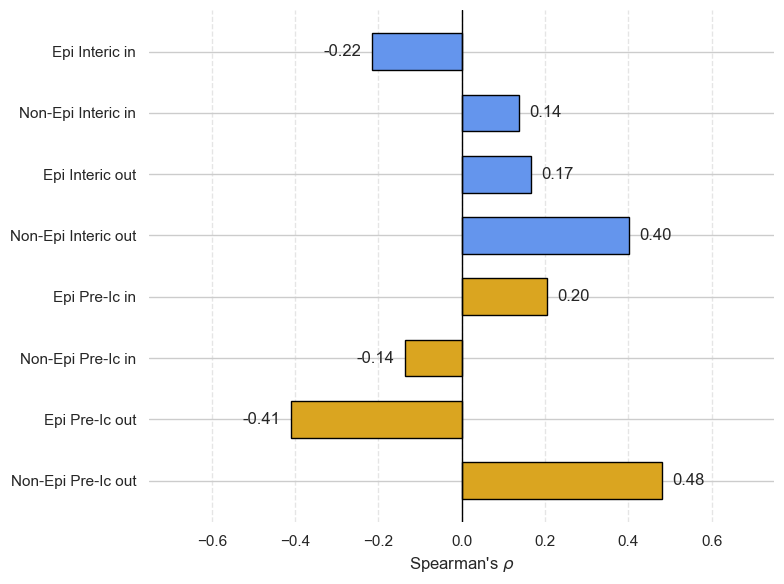

In [57]:
# Correlation values
correlations = [
    corr_fooof_inward_delta_epi_resting,
    corr_fooof_inward_delta_nonepi_resting,
    corr_fooof_outward_delta_epi_resting,
    corr_fooof_outward_delta_nonepi_resting,
    corr_fooof_inward_delta_epi,
    corr_fooof_inward_delta_nonepi,
    corr_fooof_outward_delta_epi,
    corr_fooof_outward_delta_nonepi
]

# Labels
labels = [
    "Epi Interic in",
    "Non-Epi Interic in",
    "Epi Interic out",
    "Non-Epi Interic out",
    "Epi Pre-Ic in",
    "Non-Epi Pre-Ic in",
    "Epi Pre-Ic out",
    "Non-Epi Pre-Ic out"
]

# Set Seaborn style for cleaner visuals
sns.set(style='whitegrid')

# Ensure values are floats
correlations = [float(c) for c in correlations]

# Colors: differentiate Resting vs Pre-Ictal
colors = ['goldenrod' if 'Pre-Ic' in lbl else 'cornflowerblue' for lbl in labels]

# Reverse order so first label appears at the top
correlations = correlations[::-1]
labels = labels[::-1]
colors = colors[::-1]

# Create plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, correlations, color=colors, edgecolor='black', height=0.6)

# Axis labels
plt.xlabel(r"Spearman's $\rho$")

# Grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Axis limits and ticks
plt.xlim(-0.75, 0.75)
plt.xticks()
plt.yticks()

# Annotate values with fixed offset from bar edge
offset = 0.025  # Fixed distance from bar edge

for bar in bars:
    value = bar.get_width()
    xpos = value + offset if value >= 0 else value - offset
    ha = 'left' if value >= 0 else 'right'
    plt.text(xpos, bar.get_y() + bar.get_height() / 2,
             f"{value:.2f}", va='center', ha=ha)

# Optional: add subtle divider line between RS and Pre-Ic
#plt.axhline(3.5, color='black', linestyle='--', linewidth=1, alpha=0.3)

# Remove spines
sns.despine(left=True, bottom=True)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
#plt.show()

plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 2\\Barplot correlations.png", dpi=700) 

In [58]:
from mne.stats import fdr_correction
dict_pvalues_delta = {
    'fooof_outward_delta_epi_ic': pval_fooof_outward_delta_epi,
    'fooof_outward_delta_nonepi_ic': pval_fooof_outward_delta_nonepi,
    'fooof_inward_delta_epi_ic': pval_fooof_inward_delta_epi,
    'fooof_inward_delta_nonepi_ic': pval_fooof_inward_delta_nonepi

}

rejected, pvals_corrected_delta = fdr_correction(list(dict_pvalues_delta.values()), alpha=0.05)
list(zip(dict_pvalues_delta.keys(), pvals_corrected_delta))

[('fooof_outward_delta_epi_ic', 0.06767686969292235),
 ('fooof_outward_delta_nonepi_ic', 0.04429890812428256),
 ('fooof_inward_delta_epi_ic', 0.4082295787893357),
 ('fooof_inward_delta_nonepi_ic', 0.494459682182252)]